# CHROMBPNET USAGE

This notebook demonstrates the usage of ChromBPNet through Chorus API

## Installation Instructions (Reference)

If you haven't installed Chorus yet, follow these steps:

```bash
# 1. Clone the repository
git clone https://github.com/pinellolab/chorus.git
cd chorus

# 2. Create the main Chorus environment
mamba env create -f environment.yml
mamba activate chorus

# 3. Install Chorus package
pip install -e .

# 4. Set up the Enformer environment
chorus setup --oracle chrombpnet

# 5. Download the reference genome
chorus genome download hg38
```

**Note**: 
- For this notebook, we assume Chorus is already installed.
- pyGenomeTracks is now included in the environment for advanced visualization!

# 1. Oracle Initialization

In [1]:
import chorus
from chorus.utils import get_genome, extract_sequence, download_gencode

# Get reference genome (auto-downloads if not present)
print("Setting up reference genome...")
genome_path = get_genome('hg38')
print(f"Using genome: {genome_path}")

# Download gene annotations
print("\nSetting up gene annotations...")
gtf_path = download_gencode(version='v48', annotation_type='basic')
print(f"Using annotations: {gtf_path}")

# Initialize the model
oracle = chorus.create_oracle(
    'chrombpnet',
    use_environment=True,
    reference_fasta=str(genome_path)
)

2025-11-20 15:53:18,739 - chorus.utils.annotations - INFO - Annotation file already exists: /storage_1/lruggeri/projects/chorus/annotations/gencode.v48.basic.annotation.gtf.gz
2025-11-20 15:53:18,739 - chorus.core.base - INFO - Device: auto-detect (GPU if available, else CPU)
2025-11-20 15:53:18,740 - chorus.core.environment.manager - INFO - Found conda via CONDA_EXE: /storage_1/lruggeri/miniconda3/bin/conda


Setting up reference genome...
Using genome: /storage_1/lruggeri/projects/chorus/genomes/hg38.fa

Setting up gene annotations...
Using annotations: /storage_1/lruggeri/projects/chorus/annotations/gencode.v48.basic.annotation.gtf.gz


2025-11-20 15:53:21,145 - chorus.core.base - INFO - Using conda environment: chorus-chrombpnet


# 2. Model Loading

ChromBPNet pretrained models are hosted on Zenodo, for this notebook we'll load the model trained on K562 ATAC-seq tracks. The function load_pretrained_model downloads the available weigts and return the selected one.

In [3]:
oracle.load_pretrained_model(
    assay="DNASE",
    cell_type="HepG2",
)

2025-11-20 15:49:02,706 - chorus.oracles.chrombpnet - INFO - Dowloading ChromBPNet into ....
2025-11-20 15:50:38,162 - chorus.oracles.chrombpnet - INFO - Dowload completed!
2025-11-20 15:50:42,055 - chorus.oracles.chrombpnet - INFO - Loading ChromBPNet model...
2025-11-20 15:50:45,930 - chorus.oracles.chrombpnet - INFO - ChromBPNet model loaded successfully in environment!


Alternatively, one could load its weights from disk.

In [2]:
models_weights = "./chrombpnet"

oracle.load_pretrained_model(
    weights=models_weights,
    assay="DNASE",
    cell_type="HepG2"
)

2025-11-20 15:53:25,670 - chorus.oracles.chrombpnet - INFO - Loading ChromBPNet model...
2025-11-20 15:53:28,781 - chorus.oracles.chrombpnet - INFO - ChromBPNet model loaded successfully in environment!


# 3. Making Predictions

In [3]:

tracks = ['DNASE:HepG2'] 

predictions = oracle.predict(
    ("chrX", 48777634, 48790694),
    tracks
)



## Example A: Wild-type sequence predictions

In [4]:
# Define GATA1 TSS region
gata1_region = "chrX:48777634-48790694"
print(f"Analyzing wild-type region: {gata1_region}")
print("This region contains the GATA1 transcription start site\n")

# Extract sequence information
wt_seq = extract_sequence(gata1_region, str(genome_path))
print(f"Region length: {len(wt_seq):,} bp")
print(f"GC content: {(wt_seq.count('G') + wt_seq.count('C')) / len(wt_seq) * 100:.1f}%")

Analyzing wild-type region: chrX:48777634-48790694
This region contains the GATA1 transcription start site

Region length: 13,061 bp
GC content: 47.2%


In [5]:
tracks = ["ENCFF136DBS"]

# Make predictions for wild-type sequence
print("Making predictions using specific track identifiers...")
print(f"Track IDs: {tracks}")

wt_results = oracle.predict(
    ('chrX', 48_730_000, 48_840_000),
    tracks  # Using specific track IDs
)

Making predictions using specific track identifiers...
Track IDs: ['ENCFF136DBS']


In [6]:
import numpy as np
for track_id, prediction in wt_results.items():
    print(f"\n{track_id}:")
    print(f"  Shape: {prediction.values.shape}")
    print(f"  Mean signal: {np.mean(prediction.values):.4f}")
    print(f"  Max signal: {np.max(prediction.values):.4f}")
    print(f"  Signal at TSS region (bins 40-50): {np.mean(prediction.values[40:50]):.4f}")


DNASE:HepG2:
  Shape: (110000,)
  Mean signal: 0.2756
  Max signal: 66.8286
  Signal at TSS region (bins 40-50): 0.0000



Creating visualization with gene annotations...
Saved visualization to: gata1_wt_with_genes.png


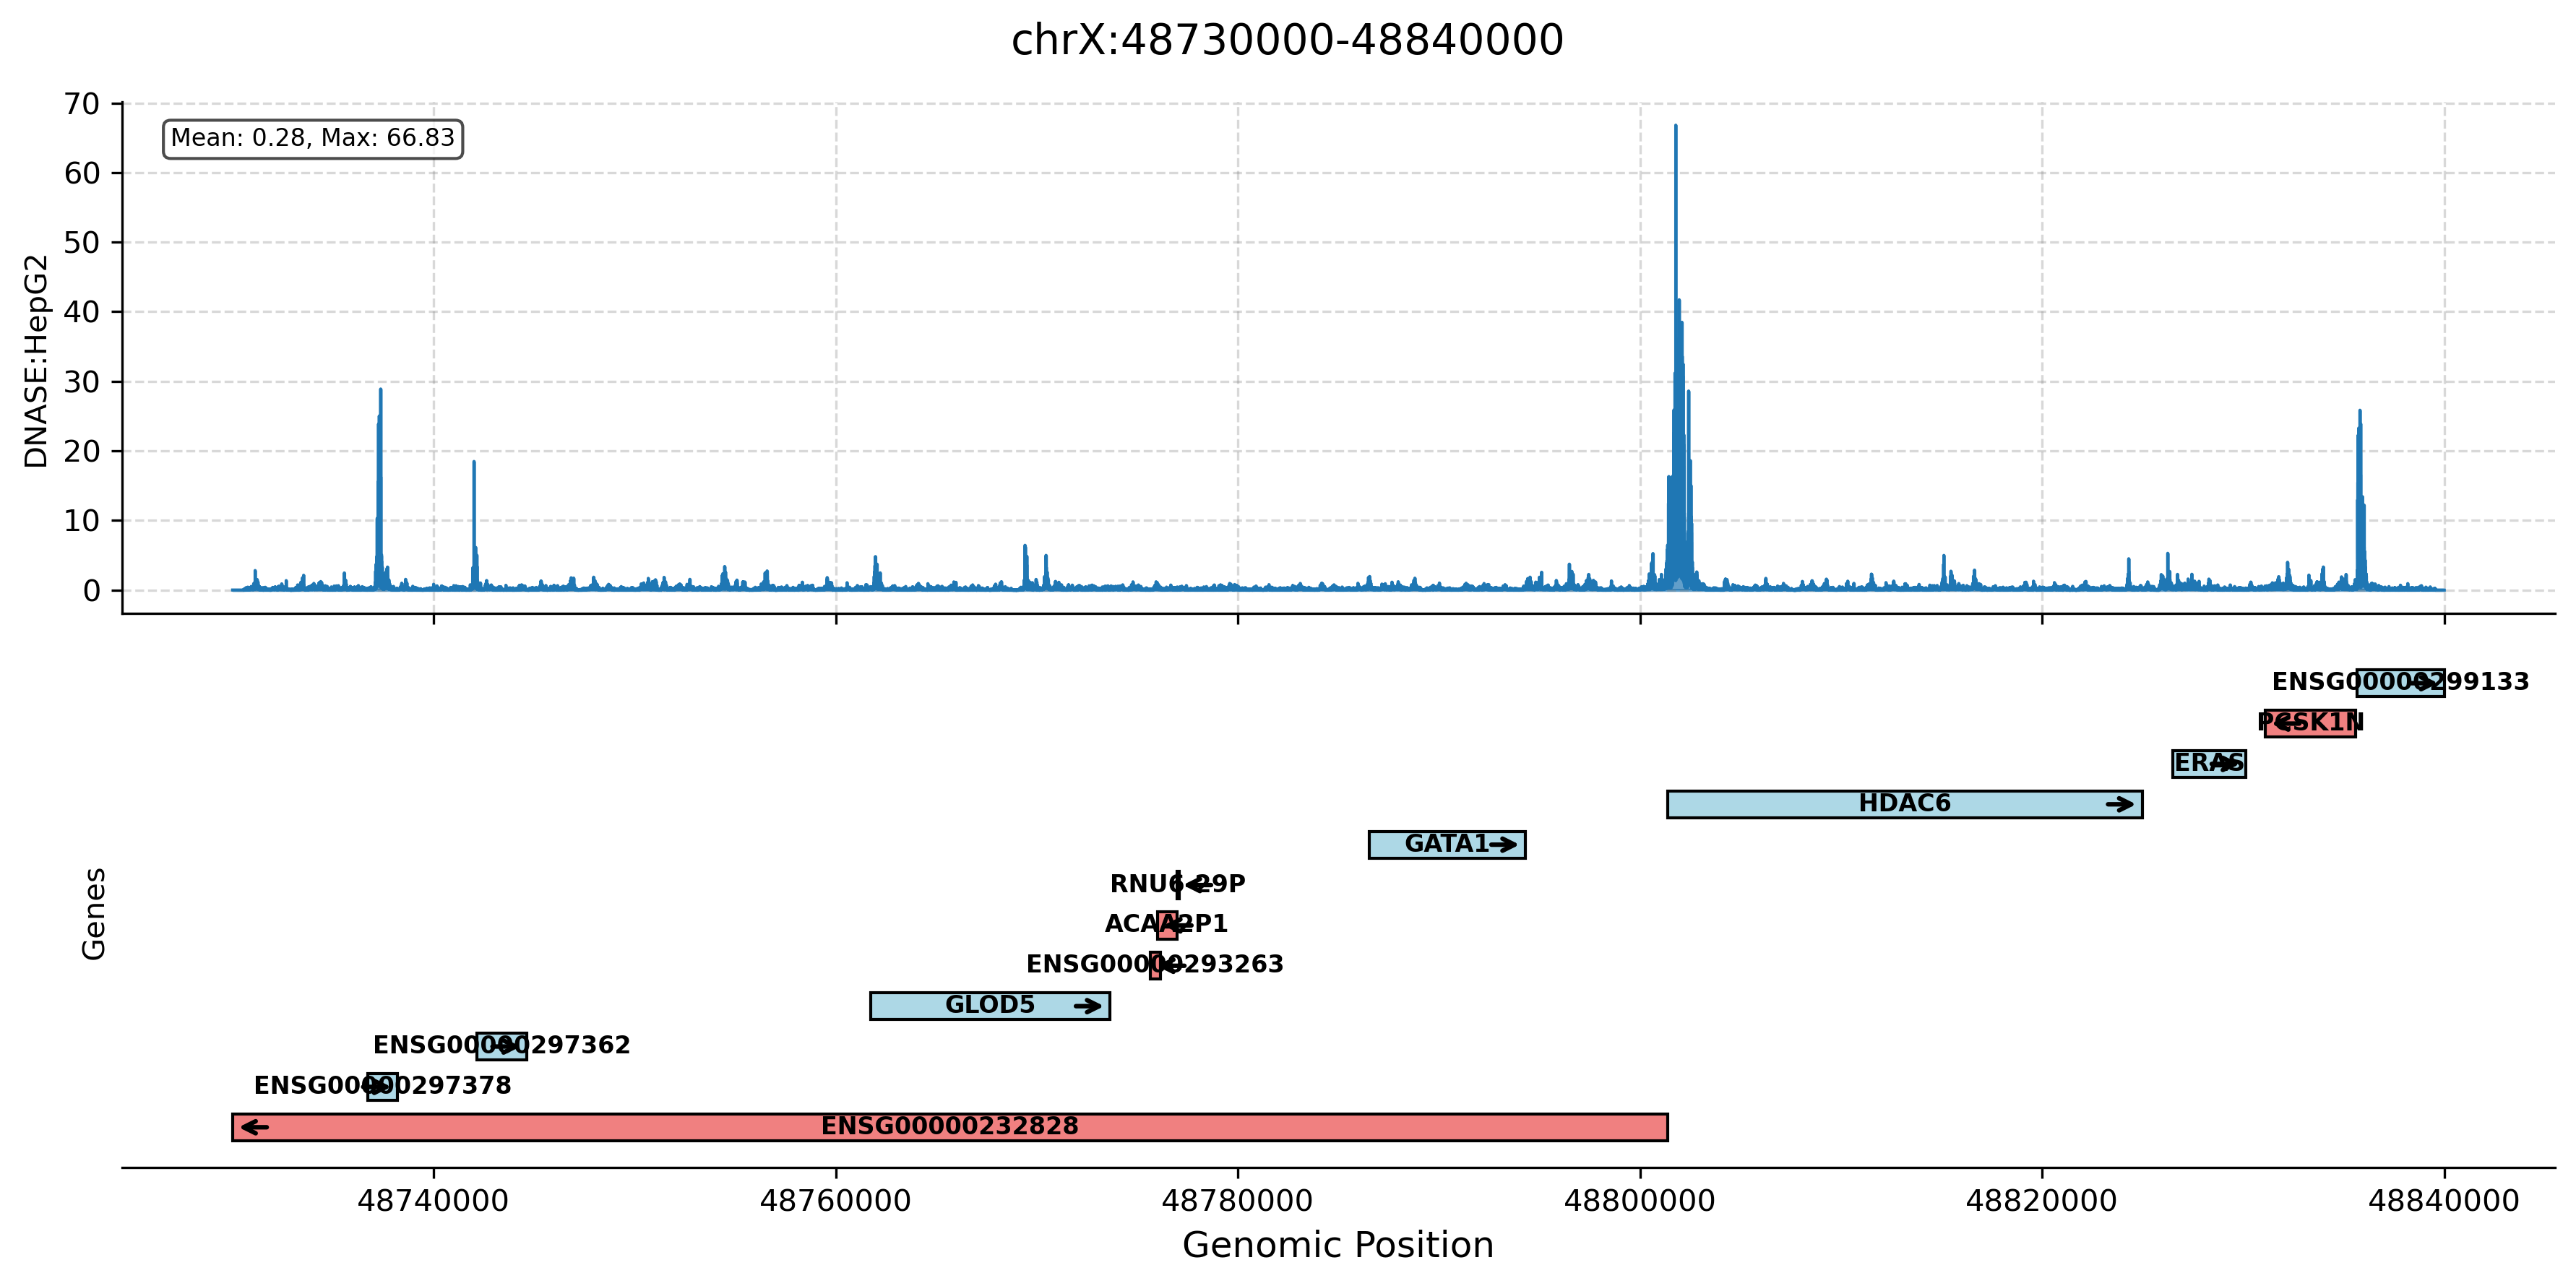

In [8]:
from chorus.utils.visualization import visualize_chorus_predictions

# For visualization, get the output window coordinates
# Create visualization with gene annotations using pyGenomeTracks
print("\nCreating visualization with gene annotations...")
try:
    visualize_chorus_predictions(
        predictions=wt_results,
        track_ids=['DNASE:HepG2'],
        output_file='gata1_wt_with_genes.png',  # Save to file for pyGenomeTracks
        gtf_file=str(gtf_path),  # Add gene annotations
        use_pygenometracks=False  # Use pyGenomeTracks for better gene visualization
    )
    print("Saved visualization to: gata1_wt_with_genes.png")
    
    # Display the saved image
    from IPython.display import Image, display
    display(Image('gata1_wt_with_genes.png', width=800))
    
except Exception as e:
    print(f"Could not create pyGenomeTracks visualization: {e}")
    print("Falling back to matplotlib visualization...")
    
    # Fallback to matplotlib for inline display
    visualize_chorus_predictions(
        predictions=wt_results,
        track_ids=['ENCFF136DBS'],
        output_file=None,  # Display inline
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )
finally:
    pass